---

In [1]:
# Vision Transformer (ViT) Analysis Assignment
# Task 2: Understanding Vision Transformers

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:

# =============================================================================
# Task 2.1: Using a Pre-trained ViT for Image Classification
# =============================================================================

print("=" * 60)
print("TASK 2.1: Pre-trained ViT Image Classification")
print("=" * 60)

# Load pre-trained ViT model and processor
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)
model.to(device)
model.eval()

# Load ImageNet class labels
def load_imagenet_labels():
    """Load ImageNet class labels"""
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    try:
        response = requests.get(url)
        labels = response.text.strip().split('\n')
        return labels
    except:
        # Fallback: create dummy labels
        print("exception caught, labels bad")
        return [f"class_{i}" for i in range(1000)]

imagenet_labels = load_imagenet_labels()

# Test images URLs (you can replace these with your own images)
test_images = [
    "/content/parrot.jpeg",
    "/content/plane.jpg",
    "/content/apple.jpeg",
    "/content/football.jpeg"

]

# Function to classify images
def classify_image(image_url, model, processor):
    """Classify a single image using ViT"""
    try:
        # Load and preprocess image
        if image_url.startswith('http'):
            image = Image.open(requests.get(image_url, stream=True).raw)
        else:
            image = Image.open(image_url)

        # Convert to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Process image
        inputs = processor(images=image, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get predictions
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # Get top prediction
        top_pred_idx = predictions.argmax().item()
        confidence = predictions[0, top_pred_idx].item()

        return image, top_pred_idx, confidence, predictions

    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None, None, None

# Test the model on sample images
print("\nTesting ViT on sample images:")
print("-" * 40)

results = []
for i, image_url in enumerate(test_images):
    print(f"\nImage {i+1}:")
    image, pred_idx, confidence, predictions = classify_image(image_url, model, processor)

    if image is not None:
        predicted_class = imagenet_labels[pred_idx] if pred_idx < len(imagenet_labels) else f"class_{pred_idx}"
        print(f"Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.4f}")

        # Get top 5 predictions
        top5_indices = predictions.argsort(descending=True)[0][:5]
        print("Top 5 predictions:")
        for j, idx in enumerate(top5_indices):
            label = imagenet_labels[idx.item()] if idx.item() < len(imagenet_labels) else f"class_{idx.item()}"
            conf = predictions[0, idx.item()].item()
            print(f"  {j+1}. {label}: {conf:.4f}")

        results.append((image, pred_idx, confidence, predictions))


TASK 2.1: Pre-trained ViT Image Classification


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]


Testing ViT on sample images:
----------------------------------------

Image 1:
Predicted class: lorikeet
Confidence: 0.3612
Top 5 predictions:
  1. lorikeet: 0.3612
  2. jacamar: 0.0722
  3. macaw: 0.0701
  4. mousetrap: 0.0379
  5. bee eater: 0.0186

Image 2:
Predicted class: airliner
Confidence: 0.9934
Top 5 predictions:
  1. airliner: 0.9934
  2. wing: 0.0029
  3. warplane: 0.0020
  4. space shuttle: 0.0005
  5. airship: 0.0001

Image 3:
Predicted class: Granny Smith
Confidence: 0.8084
Top 5 predictions:
  1. Granny Smith: 0.8084
  2. red wine: 0.0163
  3. banana: 0.0094
  4. orange: 0.0091
  5. lemon: 0.0070

Image 4:
Predicted class: soccer ball
Confidence: 0.9915
Top 5 predictions:
  1. soccer ball: 0.9915
  2. golf ball: 0.0028
  3. tennis ball: 0.0006
  4. baseball: 0.0005
  5. rugby ball: 0.0004



TASK 2.2: Visualizing Patch Attention


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Visualizing attention for sample images:

Attention visualization for Image 1:


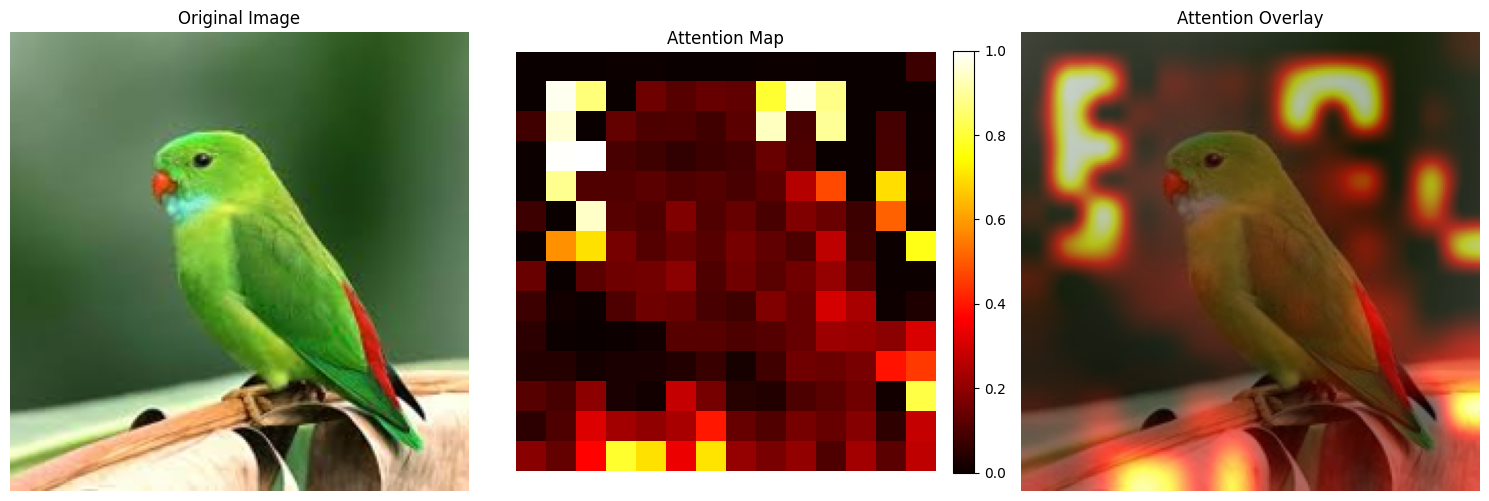


Attention visualization for Image 2:


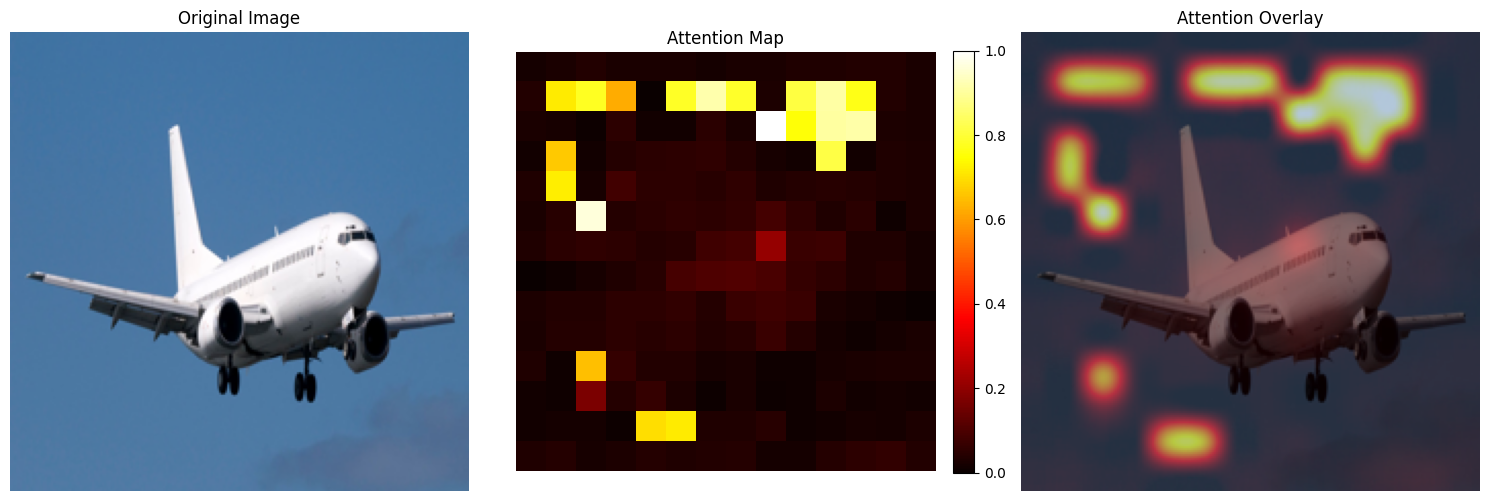


Attention visualization for Image 3:


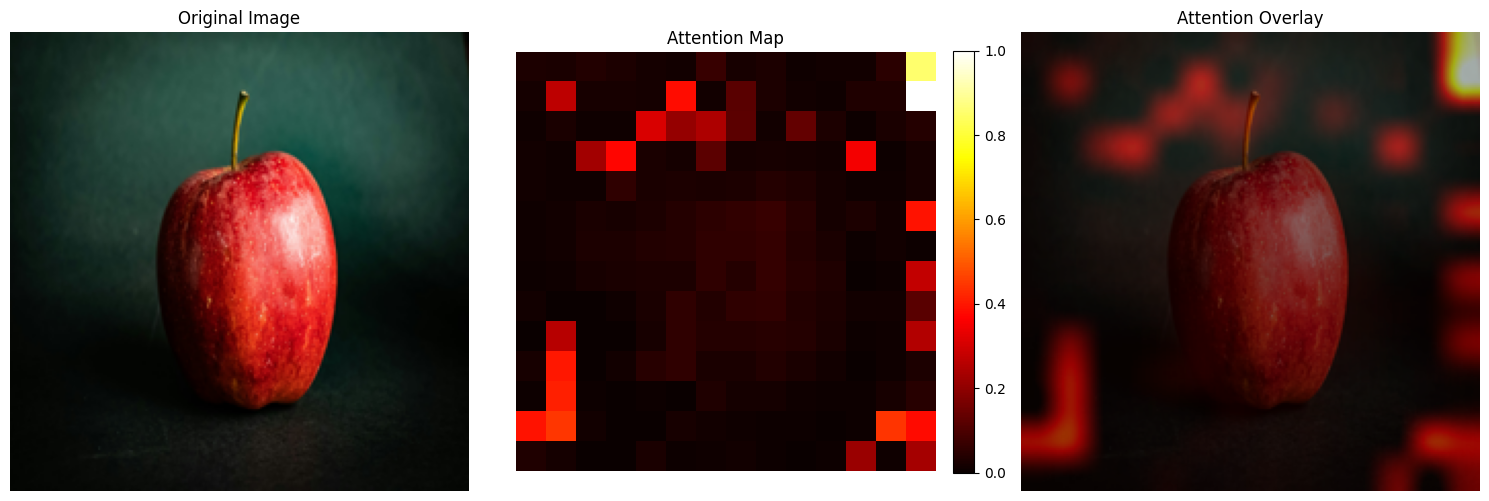

In [3]:

# =============================================================================
# Task 2.2: Visualizing Patch Attention
# =============================================================================

print("\n" + "=" * 60)
print("TASK 2.2: Visualizing Patch Attention")
print("=" * 60)

# Load ViT model that outputs attention weights
vit_model = ViTModel.from_pretrained(model_name, output_attentions=True)
vit_model.to(device)
vit_model.eval()

def get_attention_maps(image, model, processor):
    """Extract attention maps from ViT model"""
    # Preprocess image
    if isinstance(image, str):
        if image.startswith('http'):
            image = Image.open(requests.get(image, stream=True).raw)
        else:
            image = Image.open(image)

    if image.mode != 'RGB':
        image = image.convert('RGB')

    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model outputs with attention
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract attention weights from the last layer
    attention = outputs.attentions[-1]  # Shape: [batch_size, num_heads, seq_len, seq_len]

    # Get CLS token attention (first token) to all patches
    # Average across all attention heads
    cls_attention = attention[0, :, 0, 1:].mean(dim=0)  # [num_patches]

    return cls_attention, attention, image

def visualize_attention(image, attention_weights, patch_size=16):
    """Visualize attention weights as heatmap overlay"""
    # Calculate number of patches per dimension
    img_size = 224  # ViT input size
    num_patches_per_side = img_size // patch_size

    # Reshape attention to 2D grid
    attention_map = attention_weights.cpu().numpy()
    attention_2d = attention_map.reshape(num_patches_per_side, num_patches_per_side)

    # Normalize attention map
    attention_2d = (attention_2d - attention_2d.min()) / (attention_2d.max() - attention_2d.min())

    # Resize attention map to image size
    attention_resized = np.array(Image.fromarray((attention_2d * 255).astype(np.uint8)).resize((224, 224)))

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(image.resize((224, 224)))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Attention heatmap
    im1 = axes[1].imshow(attention_2d, cmap='hot', interpolation='nearest')
    axes[1].set_title("Attention Map")
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # Overlay
    axes[2].imshow(image.resize((224, 224)))
    axes[2].imshow(attention_resized, cmap='hot', alpha=0.6)
    axes[2].set_title("Attention Overlay")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return attention_2d

# Visualize attention for the first test image
if results:
    print("\nVisualizing attention for sample images:")
    for i, (image, _, _, _) in enumerate(results[:3]):
        print(f"\nAttention visualization for Image {i+1}:")
        cls_attention, full_attention, _ = get_attention_maps(image, vit_model, processor)
        attention_2d = visualize_attention(image, cls_attention)


TASK 2.3: Analyzing Different Attention Heads
Analyzing attention heads for the first image:


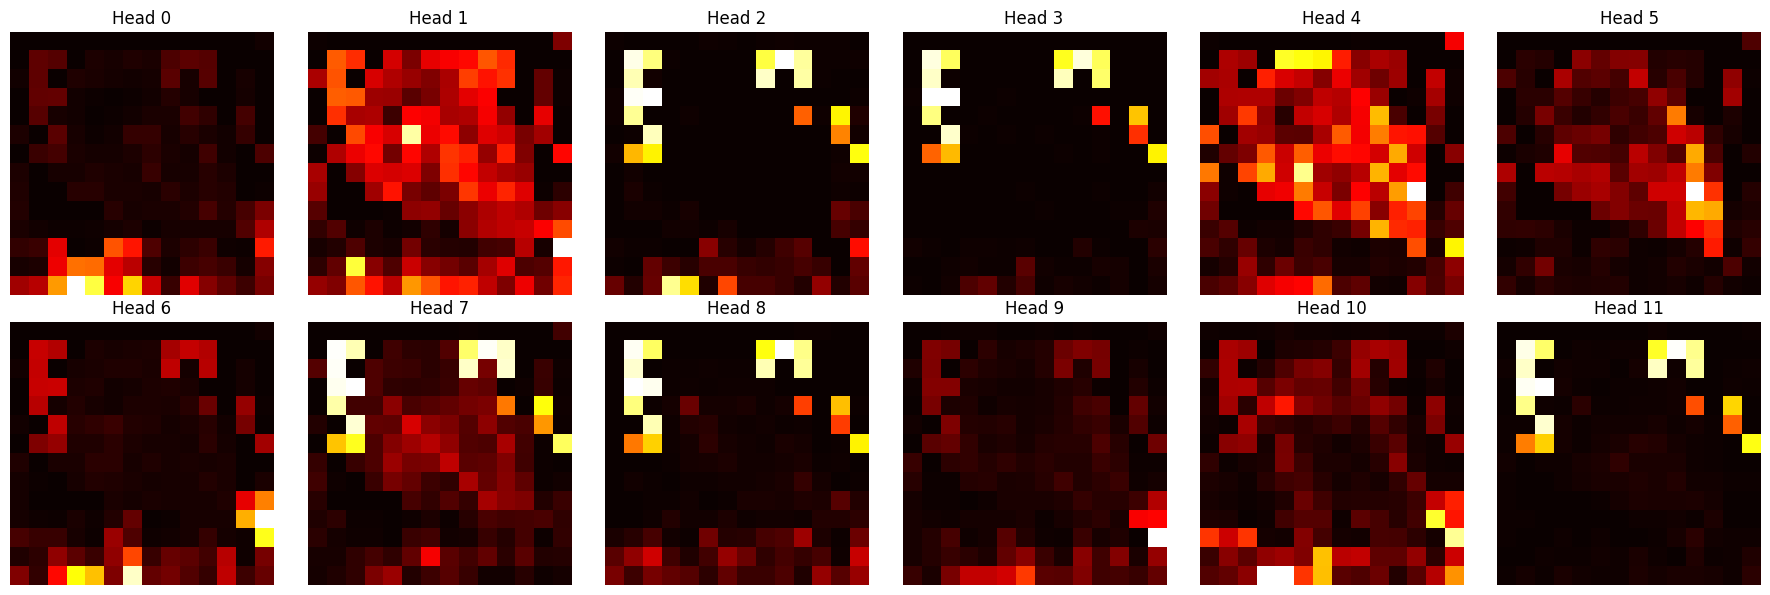

In [4]:

# =============================================================================
# Task 2.3: Analyze different attention heads
# =============================================================================

print("TASK 2.3: Analyzing Different Attention Heads")
print("=" * 60)

def analyze_attention_heads(image, model, processor, layer_idx=-1):
    """Analyze different attention heads"""
    cls_attention, full_attention, processed_image = get_attention_maps(image, model, processor)

    # Get attention from specific layer
    layer_attention = full_attention[layer_idx]  # [num_heads, seq_len, seq_len]
    cls_attention_per_head = layer_attention[:, 0, 1:]  # [num_heads, num_patches]

    num_heads = cls_attention_per_head.shape[0]
    num_patches_per_side = int(np.sqrt(cls_attention_per_head.shape[1]))

    # Visualize different heads
    fig, axes = plt.subplots(2, 6, figsize=(18, 6))
    axes = axes.flatten()

    for head in range(min(12, num_heads)):  # Show first 12 heads
        attention_head = cls_attention_per_head[head].cpu().numpy()
        attention_2d = attention_head.reshape(num_patches_per_side, num_patches_per_side)
        attention_2d = (attention_2d - attention_2d.min()) / (attention_2d.max() - attention_2d.min())

        im = axes[head].imshow(attention_2d, cmap='hot')
        axes[head].set_title(f"Head {head}")
        axes[head].axis('off')

    plt.tight_layout()
    plt.show()

    return cls_attention_per_head

# Analyze attention heads for first image
if results:
    print("Analyzing attention heads for the first image:")
    head_attention = analyze_attention_heads(results[0][0], vit_model, processor)


TASK 2.4: Patch Masking Robustness
Testing patch masking robustness:

Masking Results:
no_mask: lorikeet (confidence: 0.3612)
random_0.1: lorikeet (confidence: 0.3106)
center_0.1: lorikeet (confidence: 0.1853)
random_0.3: lorikeet (confidence: 0.4600)
center_0.3: vine snake (confidence: 0.1000)
random_0.5: lorikeet (confidence: 0.2816)
center_0.5: pencil sharpener (confidence: 0.0670)


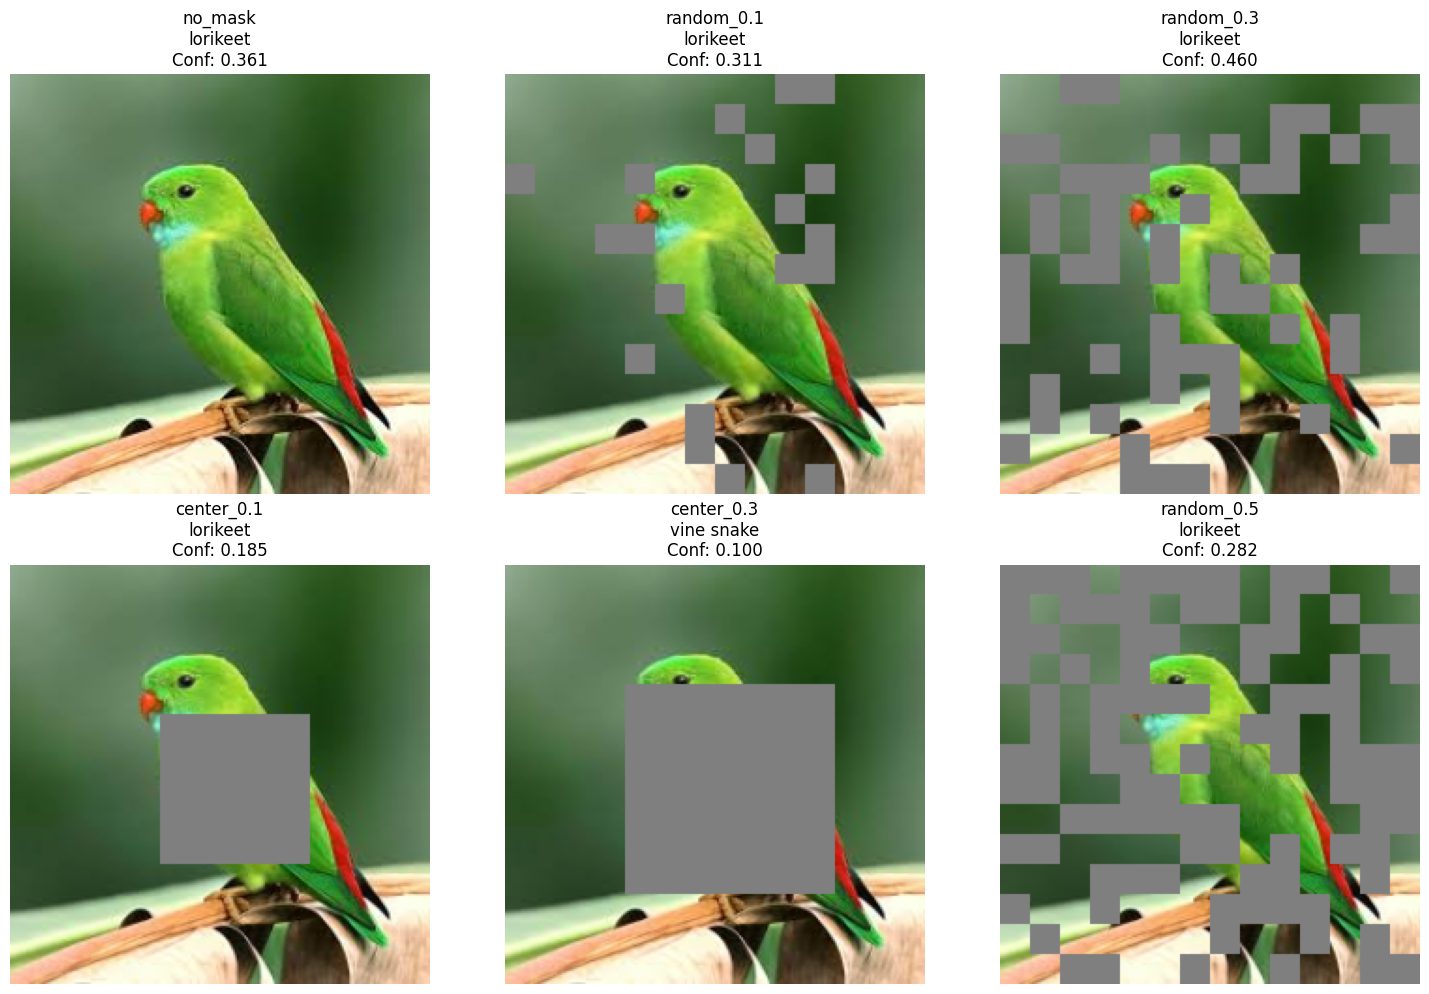

In [5]:

# =============================================================================
# Task 2.4: Masking Patches at Inference
# =============================================================================

print("\n" + "=" * 60)
print("TASK 2.4: Patch Masking Robustness")
print("=" * 60)

def mask_patches(pixel_values, mask_ratio=0.15, mask_type='random'):
    """Mask patches in the input image"""
    batch_size, channels, height, width = pixel_values.shape
    patch_size = 16
    num_patches_h = height // patch_size
    num_patches_w = width // patch_size
    num_patches = num_patches_h * num_patches_w

    masked_pixel_values = pixel_values.clone()

    if mask_type == 'random':
        # Random masking
        num_masked = int(num_patches * mask_ratio)
        patch_indices = torch.randperm(num_patches)[:num_masked]

        for idx in patch_indices:
            patch_h = idx // num_patches_w
            patch_w = idx % num_patches_w

            h_start = patch_h * patch_size
            h_end = h_start + patch_size
            w_start = patch_w * patch_size
            w_end = w_start + patch_size

            masked_pixel_values[:, :, h_start:h_end, w_start:w_end] = 0

    elif mask_type == 'center':
        # Center masking
        center_h, center_w = num_patches_h // 2, num_patches_w // 2
        mask_size = int(np.sqrt(num_patches * mask_ratio))

        for h in range(max(0, center_h - mask_size//2), min(num_patches_h, center_h + mask_size//2 + 1)):
            for w in range(max(0, center_w - mask_size//2), min(num_patches_w, center_w + mask_size//2 + 1)):
                h_start = h * patch_size
                h_end = h_start + patch_size
                w_start = w * patch_size
                w_end = w_start + patch_size

                masked_pixel_values[:, :, h_start:h_end, w_start:w_end] = 0

    return masked_pixel_values

def test_masking_robustness(image, model, processor, mask_ratios=[0.0, 0.1, 0.3, 0.5]):
    """Test model robustness to patch masking"""
    # Preprocess image
    if isinstance(image, str):
        if image.startswith('http'):
            image = Image.open(requests.get(image, stream=True).raw)
        else:
            image = Image.open(image)

    if image.mode != 'RGB':
        image = image.convert('RGB')

    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values'].to(device)

    results = {}

    # Test different masking ratios and types
    for mask_ratio in mask_ratios:
        for mask_type in ['random', 'center']:
            if mask_ratio == 0.0 and mask_type == 'center':
                continue  # Skip duplicate no-masking case

            # Apply masking
            if mask_ratio == 0.0:
                masked_pixels = pixel_values
                key = 'no_mask'
            else:
                masked_pixels = mask_patches(pixel_values, mask_ratio, mask_type)
                key = f'{mask_type}_{mask_ratio}'

            # Get predictions
            with torch.no_grad():
                outputs = model(pixel_values=masked_pixels)
                predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

            top_pred_idx = predictions.argmax().item()
            confidence = predictions[0, top_pred_idx].item()

            results[key] = {
                'prediction': top_pred_idx,
                'confidence': confidence,
                'masked_image': masked_pixels
            }

    return results, image

# Test masking robustness
if results:
    print("Testing patch masking robustness:")
    mask_results, test_image = test_masking_robustness(results[0][0], model, processor)

    print("\nMasking Results:")
    for key, result in mask_results.items():
        pred_class = imagenet_labels[result['prediction']] if result['prediction'] < len(imagenet_labels) else f"class_{result['prediction']}"
        print(f"{key}: {pred_class} (confidence: {result['confidence']:.4f})")

    # Visualize masked images
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    plot_keys = ['no_mask', 'random_0.1', 'random_0.3', 'center_0.1', 'center_0.3', 'random_0.5']

    for i, key in enumerate(plot_keys):
        if i >= len(axes) or key not in mask_results:
            continue

        if key == 'no_mask':
            # Show original image
            axes[i].imshow(test_image.resize((224, 224)))
        else:
            # Show masked image
            masked_img = mask_results[key]['masked_image'][0].cpu().permute(1, 2, 0).numpy()
            masked_img = (masked_img - masked_img.min()) / (masked_img.max() - masked_img.min())
            axes[i].imshow(masked_img)

        pred_class = imagenet_labels[mask_results[key]['prediction']] if mask_results[key]['prediction'] < len(imagenet_labels) else f"class_{mask_results[key]['prediction']}"
        axes[i].set_title(f"{key}\n{pred_class}\nConf: {mask_results[key]['confidence']:.3f}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



TASK 2.5: Linear Probes - CLS vs Mean Pooling
Preparing dataset for linear probe comparison...
Extracting features with CLS token pooling...
Extracting features with mean pooling...
Training linear probes...

Linear Probe Results:
CLS token pooling accuracy: 1.0000
Mean pooling accuracy: 0.9259
Difference: 0.0741


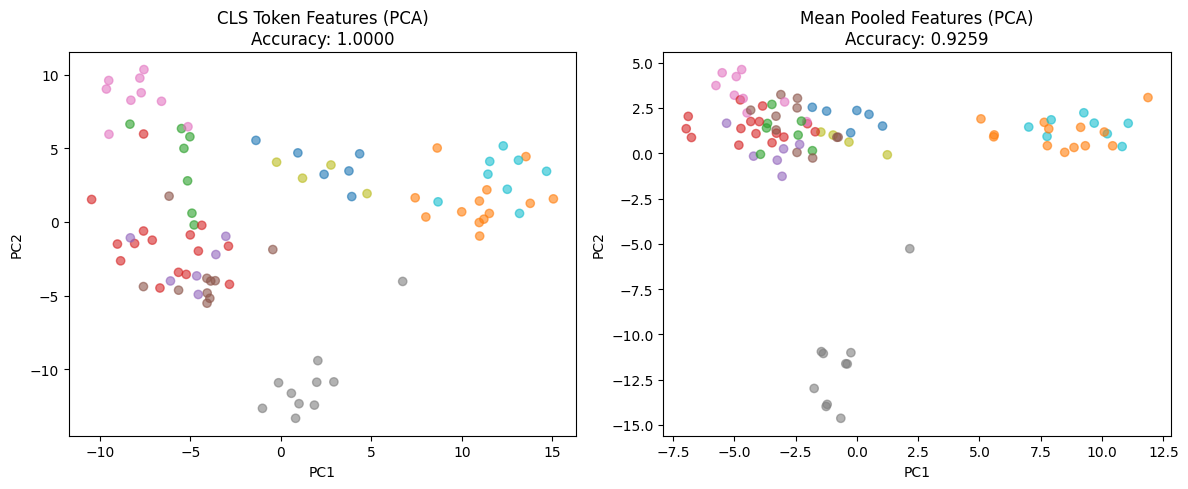

In [8]:

# =============================================================================
# Task 2.5: Linear Probes - CLS vs Mean Pooling
# =============================================================================

print("\n" + "=" * 60)
print("TASK 2.5: Linear Probes - CLS vs Mean Pooling")
print("=" * 60)

def extract_features(model, dataloader, pooling_method='cls'):
    """Extract features using different pooling methods"""
    features = []
    labels = []

    model.eval()
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dataloader):
            if batch_idx > 10:  # Limit for demo purposes
                break

            images = images.to(device)

            # Get model outputs
            outputs = model(pixel_values=images)

            if pooling_method == 'cls':
                # Use CLS token (first token)
                batch_features = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]
            elif pooling_method == 'mean':
                # Use mean of patch tokens (exclude CLS token)
                batch_features = outputs.last_hidden_state[:, 1:, :].mean(dim=1)  # [batch_size, hidden_size]

            features.append(batch_features.cpu())
            labels.append(targets)

    return torch.cat(features, dim=0).numpy(), torch.cat(labels, dim=0).numpy()

# Create a simple dataset for testing (using a subset of CIFAR-10 for demonstration)
print("Preparing dataset for linear probe comparison...")

# Transform for ViT input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

try:
    # Load CIFAR-10 dataset
    dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Use a small subset for demonstration
    indices = torch.randperm(len(dataset))[:1000]  # Use 200 samples
    subset = Subset(dataset, indices)
    dataloader = DataLoader(subset, batch_size=8, shuffle=False)

    # Extract features using both pooling methods
    print("Extracting features with CLS token pooling...")
    cls_features, labels = extract_features(vit_model, dataloader, 'cls')

    print("Extracting features with mean pooling...")
    mean_features, _ = extract_features(vit_model, dataloader, 'mean')

    # Train linear probes
    print("Training linear probes...")

    # Split data
    X_cls_train, X_cls_test, y_train, y_test = train_test_split(cls_features, labels, test_size=0.3, random_state=42)
    X_mean_train, X_mean_test, _, _ = train_test_split(mean_features, labels, test_size=0.3, random_state=42)

    # Train classifiers
    cls_classifier = LogisticRegression(max_iter=1000, random_state=42)
    mean_classifier = LogisticRegression(max_iter=1000, random_state=42)

    cls_classifier.fit(X_cls_train, y_train)
    mean_classifier.fit(X_mean_train, y_train)

    # Evaluate
    cls_pred = cls_classifier.predict(X_cls_test)
    mean_pred = mean_classifier.predict(X_mean_test)

    cls_accuracy = accuracy_score(y_test, cls_pred)
    mean_accuracy = accuracy_score(y_test, mean_pred)

    print(f"\nLinear Probe Results:")
    print(f"CLS token pooling accuracy: {cls_accuracy:.4f}")
    print(f"Mean pooling accuracy: {mean_accuracy:.4f}")
    print(f"Difference: {abs(cls_accuracy - mean_accuracy):.4f}")

    # Visualize feature distributions
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # PCA visualization of features
    from sklearn.decomposition import PCA

    pca_cls = PCA(n_components=2)
    pca_mean = PCA(n_components=2)

    cls_2d = pca_cls.fit_transform(cls_features)
    mean_2d = pca_mean.fit_transform(mean_features)

    scatter1 = axes[0].scatter(cls_2d[:, 0], cls_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    axes[0].set_title(f'CLS Token Features (PCA)\nAccuracy: {cls_accuracy:.4f}')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')

    scatter2 = axes[1].scatter(mean_2d[:, 0], mean_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    axes[1].set_title(f'Mean Pooled Features (PCA)\nAccuracy: {mean_accuracy:.4f}')
    axes[1].set_xlabel('PC1')
    axes[1].set_ylabel('PC2')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error in linear probe analysis: {e}")
    print("This is likely due to dataset download issues. The concept remains valid.")

print("\n" + "=" * 60)

Preparing dataset for linear probe comparison...
Extracting features with CLS token pooling...
Extracting features with mean pooling...
Training linear probes...

Linear Probe Results:
CLS token pooling accuracy: 0.9630
Mean pooling accuracy: 0.9259
Difference: 0.0370


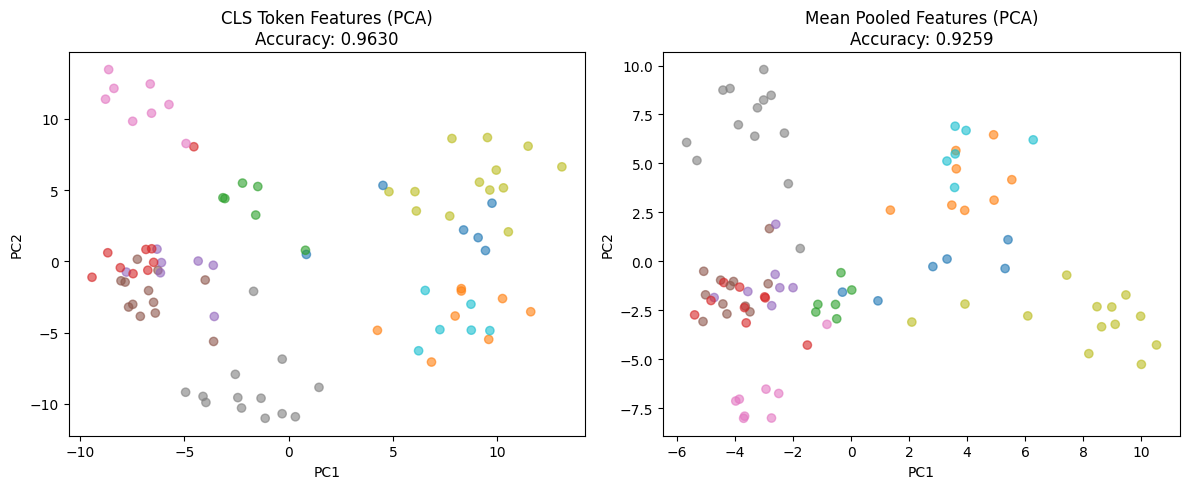

In [7]:
def extract_features(model, dataloader, pooling_method='cls'):
    """Extract features using different pooling methods"""
    features = []
    labels = []

    model.eval()
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dataloader):
            if batch_idx > 10:  # Limit for demo purposes
                break

            images = images.to(device)

            # Get model outputs
            outputs = model(pixel_values=images)

            if pooling_method == 'cls':
                # Use CLS token (first token)
                batch_features = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]
            elif pooling_method == 'mean':
                # Use mean of patch tokens (exclude CLS token)
                batch_features = outputs.last_hidden_state[:, 1:, :].mean(dim=1)  # [batch_size, hidden_size]

            features.append(batch_features.cpu())
            labels.append(targets)

    return torch.cat(features, dim=0).numpy(), torch.cat(labels, dim=0).numpy()

# Create a simple dataset for testing (using a subset of CIFAR-10 for demonstration)
print("Preparing dataset for linear probe comparison...")

# Transform for ViT input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

try:
    # Load CIFAR-10 dataset
    dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Use a small subset for demonstration
    indices = torch.randperm(len(dataset))[:200]  # Use 200 samples
    subset = Subset(dataset, indices)
    dataloader = DataLoader(subset, batch_size=8, shuffle=False)

    # Extract features using both pooling methods
    print("Extracting features with CLS token pooling...")
    cls_features, labels = extract_features(vit_model, dataloader, 'cls')

    print("Extracting features with mean pooling...")
    mean_features, _ = extract_features(vit_model, dataloader, 'mean')

    # Train linear probes
    print("Training linear probes...")

    # Split data
    X_cls_train, X_cls_test, y_train, y_test = train_test_split(cls_features, labels, test_size=0.3, random_state=42)
    X_mean_train, X_mean_test, _, _ = train_test_split(mean_features, labels, test_size=0.3, random_state=42)

    # Train classifiers
    cls_classifier = LogisticRegression(max_iter=1000, random_state=42)
    mean_classifier = LogisticRegression(max_iter=1000, random_state=42)

    cls_classifier.fit(X_cls_train, y_train)
    mean_classifier.fit(X_mean_train, y_train)

    # Evaluate
    cls_pred = cls_classifier.predict(X_cls_test)
    mean_pred = mean_classifier.predict(X_mean_test)

    cls_accuracy = accuracy_score(y_test, cls_pred)
    mean_accuracy = accuracy_score(y_test, mean_pred)

    print(f"\nLinear Probe Results:")
    print(f"CLS token pooling accuracy: {cls_accuracy:.4f}")
    print(f"Mean pooling accuracy: {mean_accuracy:.4f}")
    print(f"Difference: {abs(cls_accuracy - mean_accuracy):.4f}")

    # Visualize feature distributions
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # PCA visualization of features
    from sklearn.decomposition import PCA

    pca_cls = PCA(n_components=2)
    pca_mean = PCA(n_components=2)

    cls_2d = pca_cls.fit_transform(cls_features)
    mean_2d = pca_mean.fit_transform(mean_features)

    scatter1 = axes[0].scatter(cls_2d[:, 0], cls_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    axes[0].set_title(f'CLS Token Features (PCA)\nAccuracy: {cls_accuracy:.4f}')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')

    scatter2 = axes[1].scatter(mean_2d[:, 0], mean_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    axes[1].set_title(f'Mean Pooled Features (PCA)\nAccuracy: {mean_accuracy:.4f}')
    axes[1].set_xlabel('PC1')
    axes[1].set_ylabel('PC2')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error in linear probe analysis: {e}")
    print("This is likely due to dataset download issues. The concept remains valid.")

print("\n" + "=" * 60)